# Estimasi Hiposentrum Gempa Menggunakan Metode Stasiun Tunggal

## Dalam Jupyter Notebook, kita akan melihat bagaimana memperkirakan hiposenter gempa menggunakan bentuk gelombang yang terekam di satu stasiun

In [1]:
import numpy as np
from obspy import read, Trace, Stream
import matplotlib.pyplot as plt
from obspy import read, UTCDateTime as UTC
from obspy.clients.fdsn import Client
from sshypo_utils import read_picks, calc_rms, calc_polarity, create_ts_tp_grid, calc_hypo_lat_lon, getEndpoint
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes
import contextily as ctx
from obspy.geodetics.base import kilometer2degrees as km2deg
import os
# %matplotlib inline
from obspy.clients.fdsn.header import FDSNNoDataException, FDSNException

### We will create a folder to store the data for the event.

In [2]:
output_folder="2020_August_29_EQ_Analysis"

##### create output folder if it does not exist #####
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

### We will download the data now.
We will remove the instrument response and filter the data using a bandpass filter. We will also plot the waveforms to make sure we have an earthquake signal in them. 

/opt/miniconda3/lib/python3.9/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


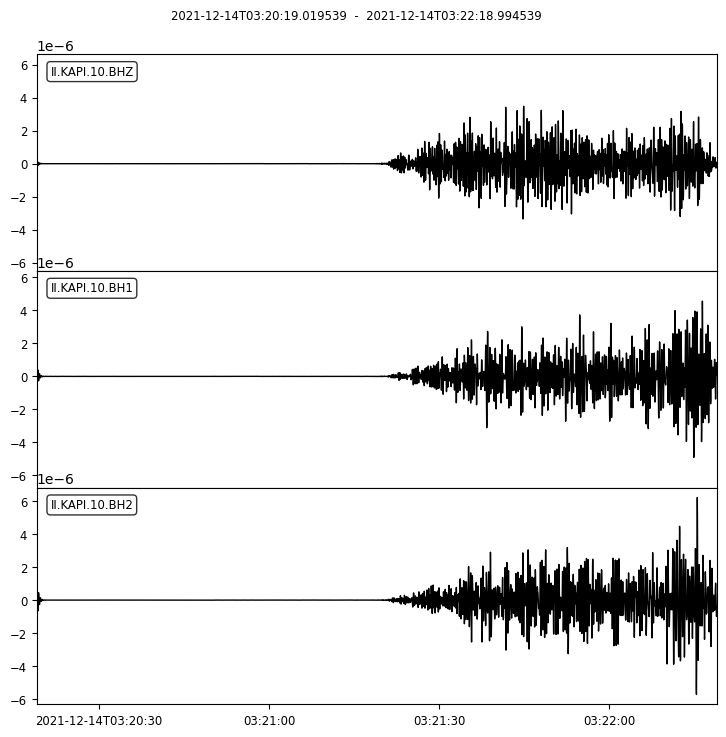

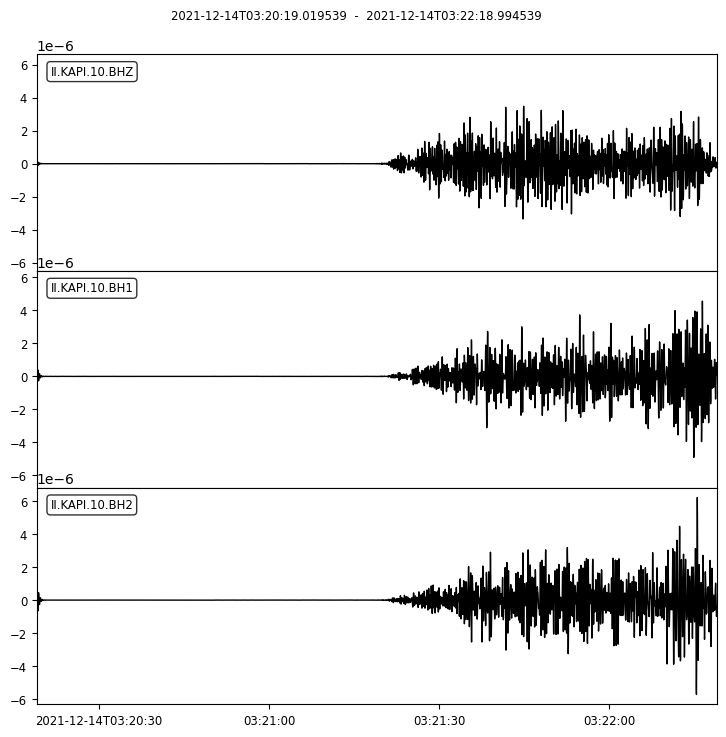

In [3]:
##### define station information #####
clients = np.array(["IRIS"])
networks = np.array(["II"])

stations = np.array(["KAPI"])
location_codes = np.array(["10"])
components = np.array(["BH?"])  #? to wildcard the three orthogonal components

##### guesstimate of the origin time #####
origin_time = UTC("2021-12-14T03:20:19.0000")
end_time = origin_time + 120

##### download data for the station(s) defined above #####
##### remove response, detrend, and write to a mseed file #####
##### filter data for plotting, plot the waveforms and save it to a file #####
for s, station in enumerate(stations):
    print ("Downloading data for {:s}".format(station))
    try:
        client = Client(clients[s])
        stream = client.get_waveforms(networks[s], stations[s], location_codes[s], components[s], origin_time, end_time, attach_response=True)
        stream.remove_response(output='DISP')
        stream.detrend()
        stream.write("{:s}/Event_{:s}.mseed".format(output_folder,stations[s]), format="mseed")
        stream.filter("bandpass", freqmin=3, freqmax=8)
        stream.sort()
        stream.plot()
        stream.plot(outfile="{:s}/Event_{:s}.png".format(output_folder,stations[s]))
    except FDSNNoDataException:
        print ("No Data")
        pass

### Now, we will read in P and S arrival picks. Note that the arrivals have been picked using Snuffler of Pyrocko package. 

In [4]:
##### name of the file with P and S arrival picks #####
pick_file = output_folder+"/"+"Event_KAPI.picks"
p_pick, s_pick = read_picks(pick_file)[0]["p_pick_time"], read_picks(pick_file)[0]["s_pick_time"]

p_arrival = UTC(p_pick)
s_arrival = UTC(s_pick)

##### calculate S-P travel time lag
sp_time_lag = s_arrival - p_arrival

print ("S-P Time:", sp_time_lag)

S-P Time: 43.0


### Now, we will trim the stream to get the samples within the peak defined by the P arrival

In [7]:
##### time window of the p arrival after its onset #####
dt = 0.1 # seconds
trimmed_stream = stream.trim(p_arrival, p_arrival+dt)

if trimmed_stream[0].stats.channel[2] == "E" or trimmed_stream[0].stats.channel[2] == "2":
    h2 = trimmed_stream[0]
    h1 = trimmed_stream[1]
    z = trimmed_stream[2]
    
else:
    h1 = trimmed_stream[0]
    h2 = trimmed_stream[1]
    z = trimmed_stream[2]

##### amplitudes within the P-window #####
p_h1 = h1.data
p_h2 = h2.data
p_z = z.data

##### calculate RMS of the P-window amplitudes #####
p_h1_rms = calc_rms(p_h1)
p_h2_rms = calc_rms(p_h2)
p_z_rms = calc_rms(p_z)

p_h1_pol = calc_polarity(p_h1)
p_h2_pol = calc_polarity(p_h2)
p_z_pol = calc_polarity(p_z)

### Now we will calculate polarisation angle (alpha) of P-arrival between the two horizontal components. We also will retrieve station metadata (component azimuths, dips, location)

In [8]:
##### calculate polarisation angle #####
alpha = np.rad2deg(np.arctan(p_h2_rms/p_h1_rms))

print ("Polarisation angle: {:6.2f}".format(alpha))

##### retrieve station metadata #####
client = Client(clients[0])
network = networks[0]
station = stations[0]
location_code = location_codes[0]
inventory = client.get_stations(network=network, station=station, level="channel", starttime=origin_time.date)

seed_id = "{:s}.{:s}.{:s}".format(network, station, location_code)

h1_azimuth = inventory.get_orientation(seed_id + "." + h1.stats.channel, origin_time.date)['azimuth']
h2_azimuth = inventory.get_orientation(seed_id + "." + h2.stats.channel, origin_time.date)['azimuth']
z_dip = inventory.get_orientation(seed_id + "." + z.stats.channel, origin_time.date)['dip']
station_latitude = inventory.get_coordinates(seed_id + "." + z.stats.channel, origin_time.date)['latitude']
station_longitude = inventory.get_coordinates(seed_id + "." + z.stats.channel, origin_time.date)['longitude']
station_elevation = inventory.get_coordinates(seed_id + "." + z.stats.channel, origin_time.date)['elevation']
station_local_depth = inventory.get_coordinates(seed_id + "." + z.stats.channel, origin_time.date)['local_depth']

print ("H1 azimuth: {:6.3f} | H2 azimuth: {:6.3f} | Z dip: {:6.3f}".format(h1_azimuth, h2_azimuth, z_dip))

##### resolve ambiguity in the backazimuth using polarity of p-wave arrival on the vertical component #####
if p_z_pol > 0:
    baz = (h1_azimuth + alpha + 180) % 360
    
elif p_z_pol < 0:
    baz = h1_azimuth + alpha
        
##### calculate radial displacement amplitude #####        
A_rad = np.sqrt(p_h1_rms**2 + p_h2_rms**2)
A_z = p_z_rms

##### calculate apparent incident angle #####
app_incidence = np.rad2deg(np.arctan(A_rad/A_z))

##### define vp/vs at the station from a priori information #####
vp_vs_station = 1.67

# true_incidence = np.rad2deg(np.arcsin(vp_vs_station*np.sin(0.5*np.deg2rad(app_incidence))))
##### in this case,we consider true incidence angle to be similar to apparent incidence angle
true_incidence = app_incidence

print ("Backazimuth: {:6.2f} | Incident angle: {:6.2f}".format(baz, true_incidence))

Polarisation angle:  51.23
H1 azimuth:  5.800 | H2 azimuth: 95.800 | Z dip: -90.000
Backazimuth:  57.03 | Incident angle:  52.80


### Next we will create a half-space crustal velocity model thought the seismic station to calculate the hypocenter of the earthquake. We consider the halfspace velocity model to be along the profile along the backazimuth from the station

**xmin, xmax, dx** defines the model domain along the x-axis (dx is velocity grid spacing along x-axis)
**zmin, zmax, dz** defines the model domain along the z-axis (dz is the velocity grid spacing along z-axis).
Note that the seismic station is located at (0,0) coordinate

In [9]:
##### define parameters for the halfspace velocity model using a priori information #####
xmin, xmax, dx = -200, 200, 0.1
zmin, zmax, dz = 0, 200, 0.1
vp = 0.5
vs = 0.3
x = np.arange(xmin, xmax, dx)
z = np.arange(zmin,zmax, dz)

##### define a travel time pick error to calculate the tsp time contour on the halfspace velocity model #####
t_err = 0.02

##### calculate the origin time #####
origin_time = p_arrival - sp_time_lag/(vp/vs -1)
ts_tp_grid, ts_tp_arc_distance = create_ts_tp_grid(x, z, vp, vs, sp_time_lag, t_err)
hypo_depth = ts_tp_arc_distance*np.cos(np.deg2rad(true_incidence))
hypo_radius = ts_tp_arc_distance*np.sin(np.deg2rad(true_incidence))

# hypo_longitude, hypo_latitude = calc_hypo_lat_lon(station_latitude, station_longitude,  hypo_radius, baz)
hypo_longitude, hypo_latitude = getEndpoint(station_latitude, station_longitude,  hypo_radius, baz)
hypo_radius_deg = km2deg(hypo_radius)

print("Origin time (UTC): {:s} | Hypocenter longitude: {:8.5f}, latitude: {:8.5f}, depth: {:4.2f} km".format(str(origin_time), hypo_longitude, hypo_latitude, hypo_depth))

Origin time (UTC): 2021-12-14T03:20:14.500000Z | Hypocenter longitude: 119.94600, latitude: -4.88774, depth: 19.50 km


### Now we will plot the results

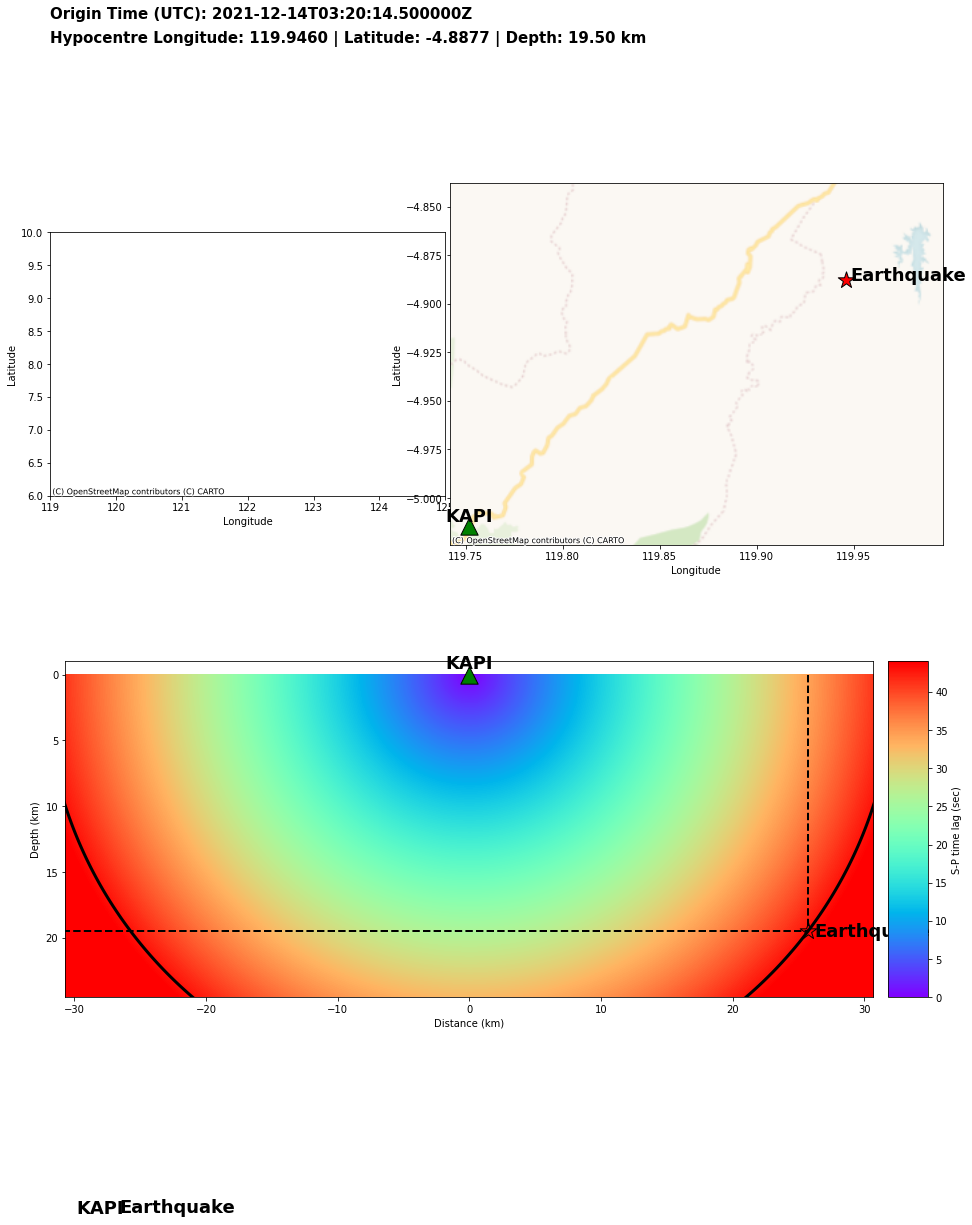

In [11]:
##### create a dataframe of station #####
station_df = pd.DataFrame({"Station": [station],
                           "Longitude": [station_longitude],
                           "Latitude": [station_latitude]})

##### create a geodataframe using the station dataframe #####
station_gdf = gpd.GeoDataFrame(station_df, geometry=gpd.points_from_xy(station_df.Longitude, station_df.Latitude))

##### create dataframe for the hypocenter #####
hypo_df = pd.DataFrame({"Longitude": [hypo_longitude],
                        "Latitude": [hypo_latitude]})

##### create geodataframe using the hypocenter dataframe #####
hypo_gdf =gpd.GeoDataFrame(hypo_df, geometry=gpd.points_from_xy(hypo_df.Longitude, hypo_df.Latitude))

##### define arrays for the extents of a plot #####
zoomed_bbox_x = np.array([station_longitude, hypo_longitude])
zoomed_bbox_y = np.array([station_latitude, hypo_latitude])

##### define arrays for the uncertainties in location #####
depth_vline_x = np.array([hypo_radius, hypo_radius])
depth_vline_z = np.array([0, hypo_depth])

depth_hline_x = np.array([np.min(x), hypo_radius])
depth_hline_z = np.array([hypo_depth, hypo_depth])

##### import plotting libs #####
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(16, 18)) 
gs = gridspec.GridSpec(nrows=3, ncols=2, hspace=0.2, wspace=0.01, width_ratios=(0.8,1), height_ratios=(1,10,7))

##### subplot with event details #####
ax0 = plt.subplot(gs[0,:])
plt.sca(ax0)
ax0.text(0,0, "Origin Time (UTC): {}".format(origin_time), fontsize=15, fontweight='bold')
ax0.text(0,0.5, "Hypocentre Longitude: {:6.4f} | Latitude: {:6.4f} | Depth: {:4.2f} km".format(hypo_longitude, hypo_latitude, hypo_depth), fontsize=15, fontweight='bold')
# ax0.text(0,1, "ML: {}".format("3??"), fontsize=15)
ax0.set_xlim(0,2)
ax0.set_ylim(1,0)
ax0.axis('off')

###### location plot 1 (whole island) #####
ax1 = plt.subplot(gs[1,0])
plt.sca(ax1)
###### plot station (s) #####
station_gdf.plot(ax=ax1, color="green", marker="^", markersize=300, linewidths=1, edgecolors=['k'])
for st in station_gdf.itertuples(index=True, name='Pandas'):
    plt.text(st.geometry.x, st.geometry.y+0.1, st.Station, fontsize=18, fontweight='bold', ha='center')
##### plot hypocenter #####
hypo_gdf.plot(ax=ax1, color="red", marker="*", markersize=300, linewidths=1, edgecolors=['k'])
for hp in hypo_gdf.itertuples(index=True, name='Pandas'):
    plt.text(hp.geometry.x+0.1, hp.geometry.y, "Earthquake", fontsize=18, fontweight='bold', ha='left')
ctx.add_basemap(ax=ax1, crs="EPSG:4326", source=ctx.providers.CartoDB.Voyager, zoom=6)
##### full list of providers https://contextily.readthedocs.io/en/latest/providers_deepdive.html #####
# ctx.add_basemap(ax=ax1, crs="EPSG:4326", source=ctx.providers.Stamen.Terrain)
##### set plot labels and limits #####
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.set_xlim(119, 125)
ax1.set_ylim(6, 10)
ax1.set_aspect('equal')



###### location plot 2 (zoomed) #####
ax2 = plt.subplot(gs[1,1])
plt.sca(ax2)
###### plot station (s) #####
station_gdf.plot(ax=ax2, color="green", marker="^", markersize=300, linewidths=1, edgecolors=['k'])
for st in station_gdf.itertuples(index=True, name='Pandas'):
    plt.text(st.geometry.x, st.geometry.y+0.002, st.Station, fontsize=18, fontweight='bold', ha='center')
##### plot hypocenter #####
hypo_gdf.plot(ax=ax2, color="red", marker="*", markersize=300, linewidths=1, edgecolors=['k'])
for hp in hypo_gdf.itertuples(index=True, name='Pandas'):
    plt.text(hp.geometry.x+0.002, hp.geometry.y, "Earthquake", fontsize=18, fontweight='bold', ha='left')
##### add basemap from contextily #####
ctx.add_basemap(ax=ax2, crs="EPSG:4326", source=ctx.providers.CartoDB.Voyager, zoom=11)
##### set plot labels and limits #####
ax2.set_xlim(np.min(zoomed_bbox_x)-0.01, np.max(zoomed_bbox_x)+0.05)
ax2.set_ylim(np.min(zoomed_bbox_y)-0.01, np.max(zoomed_bbox_y)+0.05)
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
ax2.set_aspect('equal')


##### profile plot #####
ax3 = plt.subplot(gs[2,:])
plt.sca(ax3)
##### plot S-P time lag grid #####
tstp= ax3.imshow(ts_tp_grid, extent=(np.min(x), np.max(x), np.max(z), np.min(z)), cmap='rainbow', vmin=0, vmax=sp_time_lag+1)
##### plot station #####
ax3.scatter(0,0, marker="^", color='green', s=300, linewidths=1, edgecolors=['k'])
ax3.text(0,-0.5, "KAPI", fontsize=18, fontweight='bold', ha='center')
##### plot hypocenter #####
ax3.scatter(hypo_radius, hypo_depth, marker="*", s=300, color='red', linewidths=1, edgecolors=['k'])
ax3.text(hypo_radius+0.5,hypo_depth, "Earthquake", fontsize=18, fontweight='bold', ha='left', va='center')
##### plot S-P time lag contour on the grid #####
ax3.contour(ts_tp_grid, levels=[sp_time_lag], extent=(np.min(x), np.max(x), np.max(z), np.min(z)), origin='upper', colors='black', linewidths=3)
# ax3.clabel(tsp_contour, fontsize=18)
##### plot vertical and horizontal lines for the earthquake location #####
ax3.plot(depth_vline_x, depth_vline_z, lw=2, linestyle='dashed', color='k')
ax3.plot(depth_hline_x, depth_hline_z, lw=2, linestyle='dashed', color='k')
##### plot colorbar for S-P time lag grid
divider = make_axes_locatable(ax3)
cax3 = divider.append_axes("right", size="5%", pad=0.2)
cbar = plt.colorbar(tstp, cax=cax3, orientation='vertical', label="S-P time lag (sec)")
##### set plot labels and limits #####
ax3.set_xlim(-1*(hypo_radius+5), (hypo_radius+5))
ax3.set_ylim(hypo_depth+5, np.min(z)-1)
ax3.set_xlabel("Distance (km)")
ax3.set_ylabel("Depth (km)")


plt.savefig("Event_Analysis_"+station+".png", dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

### end

In [13]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [19]:
pip install earthengine-api

     |████████████████████████████████| 261 kB 284 kB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 121 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 13.0 MB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 121 kB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 394 kB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 228 kB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 184 kB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 80 kB 2.1 MB/s eta 0:00:01
  Created wheel for earthengine-api: filename=earthengine_api-0.1.383-py3-none-any.whl size=294257 sha256=a6950be79d5840e8ba88695944ecd5d2d2634f87135d947474543cb19333a26e
  Stored in directory: /Users/adijufriansah/Library/Caches/pip/wheels/ce/16/20/7515e107dc515

In [3]:
import ee
ee.__version__

'0.1.383'

In [8]:
import ee

# Otorisasi dan inisialisasi Earth Engine
ee.Authenticate()
ee.Initialize()

# Kode Earth Engine lainnya dapat ditambahkan di sel-sel berikutnya
dem = ee.Image('USGS/SRTMGL1_003')
vis_params = {
  'min': 0,
  'max': 4000,
  'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5'],
  'transparency': 0.5
}


In [10]:
# Import the Folium library.
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Read DEM
dem = ee.Image('USGS/SRTMGL1_003')

# Set visualization parameters.
vis_params = {
  'min': 0,
  'max': 4000,
  'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

# Create a folium map object.
my_map = folium.Map(location=[20, 0], zoom_start=3, height=500)

# Add the elevation model to the map object.
my_map.add_ee_layer(dem.updateMask(dem.gt(0)), vis_params, 'DEM')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

In [11]:
import contextily
import matplotlib.pyplot as plt

In [13]:
# Read DEM
dem = ee.Image('USGS/SRTMGL1_003')

# Set visualization parameters.
vis_params = {
  'min': 0,
  'max': 4000,
  'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5'],
    'transparency': 0.5
}

In [14]:
src = dem.getMapId(vis_params)["tile_fetcher"].url_format
src

'https://earthengine.googleapis.com/v1/projects/earthengine-legacy/maps/82302bf76471cbc4d71eafdc4e3c615a-42b3fa1a07ff52e3293bb4cc15bb7a2d/tiles/{z}/{x}/{y}'

In [15]:
sw = contextily.Place("Switzerland", source=src)

<AxesSubplot:title={'center':'Schweiz/Suisse/Svizzera/Svizra'}, xlabel='X', ylabel='Y'>

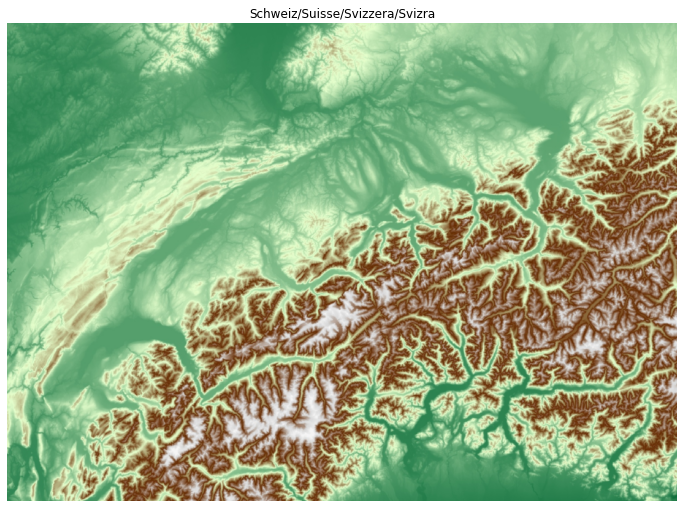

In [16]:
sw.plot()

In [21]:
sw = contextily.Place("Indonesia", source=src)

<AxesSubplot:title={'center':'Indonesia'}, xlabel='X', ylabel='Y'>

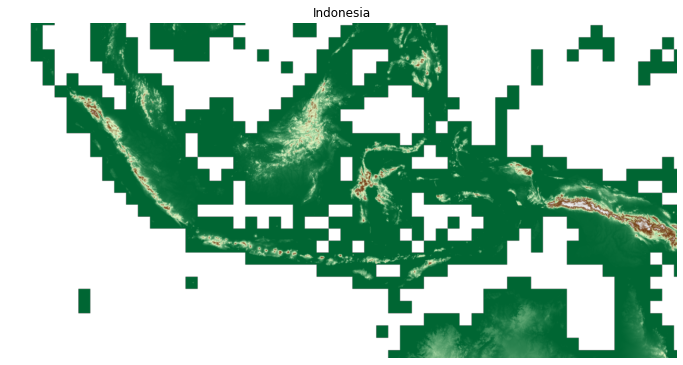

In [22]:
sw.plot()

In [23]:
sw = contextily.Place("Maumere", source=src)

<AxesSubplot:title={'center':'Maumere, Sikka, Nusa Tenggara Timur, Nusa Tenggara, 86111, Indonesia'}, xlabel='X', ylabel='Y'>

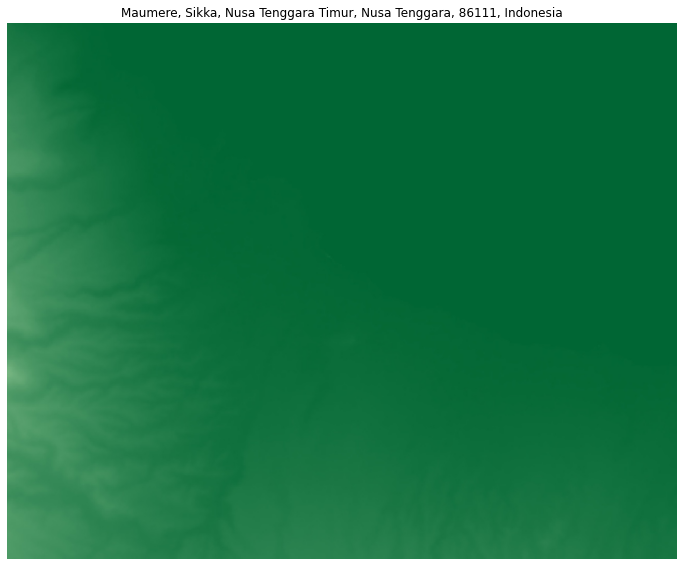

In [24]:
sw.plot()

In [25]:
sw = contextily.Place("Makassar", source=src)

<AxesSubplot:title={'center':'Makassar, Sulawesi Selatan, Sulawesi, Indonesia'}, xlabel='X', ylabel='Y'>

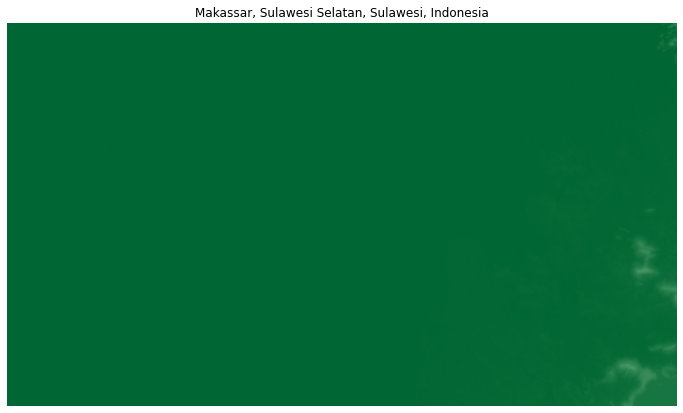

In [26]:
sw.plot()

In [17]:
l8 = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")
houston = ee.Geometry.Point(-95.3908, 29.7850)
pre = l8.filterDate("2017-07-15", "2017-08-16")\
        .filterBounds(houston)\
        .mosaic()
aft = l8.filterDate("2017-08-17", "2017-09-30")\
        .filterBounds(houston)\
        .mosaic()
viz_params = {
  "bands": ["B4", "B3", "B2"],
  "gain": '0.1, 0.1, 0.1',
  "scale":20
}

In [18]:
url_pre = pre.getMapId(viz_params)["tile_fetcher"].url_format
url_aft = aft.getMapId(viz_params)["tile_fetcher"].url_format

In [19]:
map_pre = contextily.Place("Houston, TX", source=url_pre)
map_aft = contextily.Place("Houston, TX", source=url_aft)

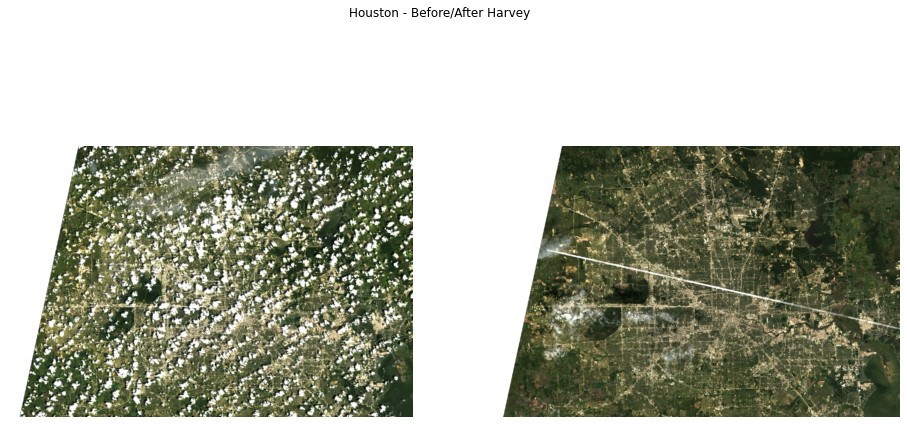

In [20]:
f, axs = plt.subplots(1, 2, figsize=(16, 8))
for i, m in enumerate([map_pre, map_aft]):
    ax = axs[i]
    m.plot(ax=ax)
    ax.set_axis_off()
f.suptitle("Houston - Before/After Harvey")
plt.show()

In [31]:
pip install rasterio

Note: you may need to restart the kernel to use updated packages.


In [35]:
!pip install --upgrade contextily

  Attempting uninstall: contextily
    Found existing installation: contextily 1.3.0
    Uninstalling contextily-1.3.0:
      Successfully uninstalled contextily-1.3.0


In [40]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [42]:
%matplotlib inline

import geopandas
import rasterio
from rasterio.plot import show as rioshow
import matplotlib.pyplot as plt

import contextily as cx
from contextily.tile import warp_img_transform, warp_tiles, _warper

In [43]:
 db = geopandas.read_file(geopandas.datasets.get_path('nybb'))

/var/folders/zv/n2g_d_rx61z5l6fj0mt0bzp80000gn/T/ipykernel_4673/1229929891.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'nybb' data from the geodatasets package.

from geodatasets import get_path
path_to_file = get_path('nybb')

  db = geopandas.read_file(geopandas.datasets.get_path('nybb'))


In [44]:
db.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [45]:
db_wm = db.to_crs(epsg=3857)

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fca30c8adb0>

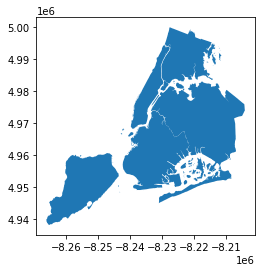

In [46]:
ax = db_wm.plot()
cx.add_basemap(ax);

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fca30d04770>

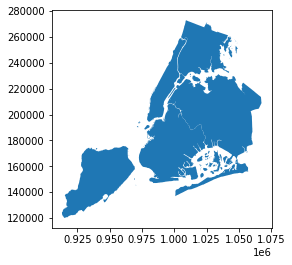

In [47]:
ax = db.plot()
cx.add_basemap(ax, crs=db.crs);

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fca30c68c70>

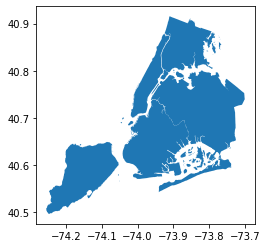

In [48]:
db_lonlat = db.to_crs(epsg=4326)
ax = db_lonlat.plot()
cx.add_basemap(ax, crs=db_lonlat.crs)